# OpenMC Tallies

**Learning Objectives:**

  - Understand application of filters and scores to create tallies
  - Apply tallies to an OpenMC simulation
  - Extract information from OpenMC statepoint files
  - Understand tally units and normalization
  - Plot basic tally results

In [2]:
import openmc
import numpy as np
from matplotlib import pyplot as plt

In this module, we'll be looking at how to extract custom information from an OpenMC simulation in what is known as a tally. A tally accumulates statistical information during the simulation about particles when they eneter regions of phase space specified on the tally. The limits of these regions are set by filters applied to the tally. Scores and nuclides can also be applied to tallies to indicate what type of information is kept about the particle (e.g. reaction types, flux, heat, etc.).

The tally capability in OpenMC takes a similar philosophy as that employed in the MC21 Monte Carlo code to give maximum flexibility in specifying tallies while still maintaining scalability. Any tally in OpenMC can be described with the following form:

$$ 
 X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
    dE}_{\text{filters}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
    E)}_{\text{scores}} \psi (\mathbf{r}, \mathbf{\Omega}, E)
$$

where filters set the limits of the integrals and the scoring function is convolved with particle information (e.g. reaction type, current material, etc.).

Tallies objects in OpenMC consist of three main components:

  - Filters
  - Scores
  - Nuclides

Creation of a tally object can be accomplished with the following. The tally filters, scores, and nuclides can be added after the fact.

In [ ]:
tally = openmc.Tally()

## Filters

There are a myriad of filters available in OpenMC that allow one to segment phase space. A full list of them can be found [here](https://docs.openmc.org/en/stable/pythonapi/base.html#pythonapi-tallies). Some of the most commonly used for basic tallies (and one's we'll explore in this module) are:

- `openmc.CellFilter`: Tally events only if they occur in the specified cells.
- `openmc.MaterialFilter`: Tally materials only if they occur in the specified materials.
- `openmc.MeshFilter`: `Tally events in the elements of a super imposed mesh.
- `openmc.EnergyFilter`: Tally events only if they occur in the given energy intervals.
- `openmc.ParticleFilter`: Tally events for a specific particle type.

When multiple filters are applied to a tally, the number of tally bins is the product of the number of bins for each filter. For example, if a `CellFilter` for 3 cells and an `EnergyFilter` with 2 energy intervals is applied, the tally will produce 6 pieces of information.

Multiple filters can be applied for the same integral limits in the equation above. For example, both a `CellFilter` and `MaterialFilter` can be applied to the sam etally object. If none of the materials specified on the `MaterialFilter` fill cells specified on the `CellFilter`, then the tally results will all be zero.

Filters can be used on more than one tally. Each event (collision, surface crossing, etc.) in OpenMC is "matched" on any of the existing filters in the model. Matches are then used to apply event information to tally results as needed. This makes the reuse of filters on multiple tallies very efficient (the same `EnergyFilter` applied to a cell tally and a mesh tally, let's say).

## Scores

Most tally scores in OpenMC can be specified using a set of the human-readable values listed [here](https://docs.openmc.org/en/stable/usersguide/tallies.html#scores). This is not an exaustive list of the tally scors available, as OpenMC supports scoring of any cross-section made available in the [ENDF MT system](https://t2.lanl.gov/nis/endf/mts.html).

In [ ]:
tally.scores = ['heating', 'fission', '(n,2n)', 444]

## Nuclides

Tally nuclides are most commonly use to separate collision events by nuclide to determine reaction rates for a specific nuclide. Combined with other filters, this can be used to identify reaction rates in specific regions of the model. By default, with no nuclides specified, the tally results represent events for any nuclide in the tally space. Conversely, the keyword "all" can be entered, which will create a tally entry for every nuclide specified in the model.

In [ ]:
tally.nuclides = ['U235', 'U238']

## Tally Complexity

Total number of bins in a tally:

$$ N_{bins} =  \underbrace{\prod_{f}^{F} N_{f}}_{filters} \times N_{scores} \times N_{nuclides} $$

## Tally Normalization

All values produced by tallies in OpenMC (and generally in Monte Carlo codes) have units _per source particle_, meaning that some normalization factor is required to translate the output values into physical units. In the simplest case, sometimes true for a fixed source calculation, this normalization factor can be applied by setting the `Source.strength` property of the external sources appropriately. 

In other cases, the source must be determined by other physical parameters. For example, in the case of an eigenvalue problem, the fission source rate is determined by the power, which is not an input parameter to the OpenMC simulation. Given a total fission rate (per source particle) and the total energy produced per fission event (per source particle) the fission source term can be determined as:

$$ \text{neutron source} [\frac{n}{s}] = \text{power} [\frac{J}{s}] \times \frac{1}{1.6\times 10^{-19}} [\frac{eV}{J}] \times \frac{1}{\text{energy per fission} [\frac{eV}{fission}]} \times \frac{1}{\text{fission rate} [\frac{fission}{n
}]}$$ 

The energy released per fission and fission rate can be combined to describe the heat released per source particle, which is exactly the units of the heating tallies provided in OpenMC. This simplifies the source term to:


$$ \text{neutron source} [\frac{n}{s}] = \text{power} [\frac{J}{s}] \times \frac{1}{1.6\times 10^{-19}} [\frac{eV}{J}] \times \frac{1}{\text{heating} [\frac{eV}{n}]}$$


## Postprocessing and Visualization

Tally results are written in two forms by OpenMC -- once in a "tallies.out" text file and in a binary form in the statpoint file. Tally information can be recovered using OpenMC's Python API.

In [ ]:
statepoint = openmc.StatePoint('statepoint.100.h5')

The tally objects (with results applied) can be acccessed via the `Statepoint.tallies` attribute, which is a dictionary with tally IDs as the keys and the tally objects as the values.

In [ ]:
# retrieve the tally with ID 1
tally = statepoint.tallies[1]

Though it's often the case that the tally IDs are known, thhe `Statepoint.get_tally` method can be used to find tallies matched by filter, scores, etc.

In [ ]:
# retrieve a tally with the 'heating' score
tally = statepoint.get_tally(scores=['heating'])

Tally data can be gathered and examined in a number of ways. The mean and standard deviation of the tally can be accessed directly as attributes of the tally. These attribues are NumPy arrays with three dimensions corresponding to the filter bins, nuclide bins, and score bins, in order.

In [ ]:
tally.mean.shape

The `Tally.get_values` method provides an option for downselecting data based on filter bins, nuclides, and scores.

In [23]:
tally.get_values?

Signature:
tally.get_values(
    scores=[],
    filters=[],
    filter_bins=[],
    nuclides=[],
    value='mean',
)
Docstring:
Returns one or more tallied values given a list of scores, filters,
filter bins and nuclides.

This method constructs a 3D NumPy array for the requested Tally data
indexed by filter bin, nuclide bin, and score index. The method will
order the data in the array as specified in the parameter lists.

Parameters
----------
scores : list of str
    A list of one or more score strings
    (e.g., ['absorption', 'nu-fission']; default is [])
filters : Iterable of openmc.FilterMeta
    An iterable of filter types
    (e.g., [MeshFilter, EnergyFilter]; default is [])
filter_bins : list of Iterables
    A list of tuples of filter bins corresponding to the filter_types
    parameter (e.g., [(1,), ((0., 0.625e-6),)]; default is []). Each
    tuple contains bins for the corresponding filter type in the filters
    parameter. Each bins is the integer ID for 'material', 'surf

Finally, tally information can be converted into a Pandas dataframe. While this is most useful for simple tallies, it's a convenient way to quickly format and plot data.

In [ ]:
statepoint = openmc.StatePoint('statepoint.100.h5')
output_tally = statepoint.tallies[1]
df = output_tally.get_pandas_dataframe()
df

,material,nuclide,score,mean,std. dev.
0,1,total,scatter,5.205780,0.011750
1,1,total,absorption,0.839049,0.005009
2,1,total,fission,0.471391,0.003075
3,2,total,scatter,1.487101,0.004985
4,2,total,absorption,0.010383,0.000115
5,2,total,fission,0.000000,0.000000
6,3,total,scatter,23.085675,0.105386
7,3,total,absorption,0.149060,0.001198
8,3,total,fission,0.000000,0.000000


## Tally Example

A full example of a tally applied to the PWR pincell model provided in the `openmc.examples` module:

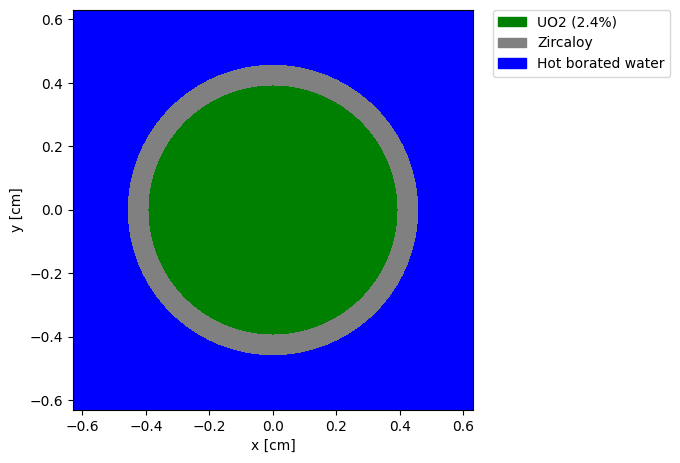

In [3]:
model = openmc.examples.pwr_pin_cell()
material_colors = ('green', 'gray', 'blue')
model.geometry.plot(pixels=(400, 400),
                    color_by='material',
                    colors={m: c for m, c in zip(model.materials, material_colors)},
                    legend=True)
plt.show()

In [6]:
# create a filter for all materials
material_filter = openmc.MaterialFilter(model.materials)

tally = openmc.Tally()
tally.filters = [material_filter]
tally.scores = ['scatter', 'absorption', 'fission']

model.tallies = [tally]

statepoint_filename = model.run(particles=10000)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [8]:
statepoint = openmc.StatePoint(statepoint_filename)
output_tally = statepoint.tallies[1]
df = output_tally.get_pandas_dataframe()
df

,material,nuclide,score,mean,std. dev.
0,1,total,scatter,5.205780,0.011750
1,1,total,absorption,0.839049,0.005009
2,1,total,fission,0.471391,0.003075
3,2,total,scatter,1.487101,0.004985
4,2,total,absorption,0.010383,0.000115
5,2,total,fission,0.000000,0.000000
6,3,total,scatter,23.085675,0.105386
7,3,total,absorption,0.149060,0.001198
8,3,total,fission,0.000000,0.000000


In [14]:
# get all materials from the geometry
materials = model.geometry.get_all_materials()
# set names based on matching material IDs
for mat_id, material in materials.items():
    df.loc[df['material'] == mat_id, 'mat_name'] = material.name
df

,material,nuclide,score,mean,std. dev.,mat_name
0,1,total,scatter,5.205780,0.011750,UO2 (2.4%)
1,1,total,absorption,0.839049,0.005009,UO2 (2.4%)
2,1,total,fission,0.471391,0.003075,UO2 (2.4%)
3,2,total,scatter,1.487101,0.004985,Zircaloy
4,2,total,absorption,0.010383,0.000115,Zircaloy
5,2,total,fission,0.000000,0.000000,Zircaloy
6,3,total,scatter,23.085675,0.105386,Hot borated water
7,3,total,absorption,0.149060,0.001198,Hot borated water
8,3,total,fission,0.000000,0.000000,Hot borated water


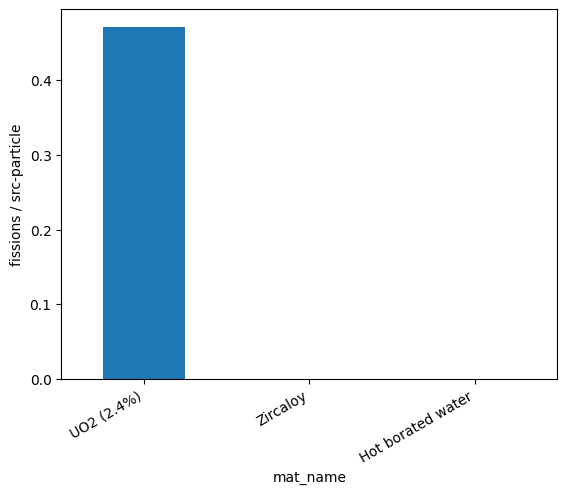

In [18]:
fission_df = df[df['score'] == 'fission']
fission_df.plot('mat_name', 'mean', ylabel='fissions / src-particle', kind='bar', legend=False)
plt.xticks(rotation=30, ha='right')
plt.show()

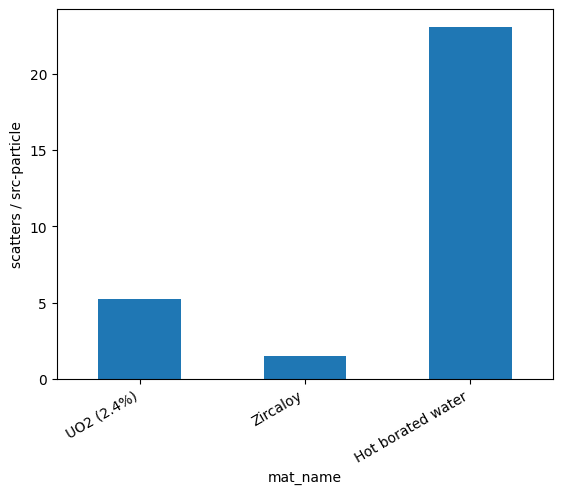

In [19]:
scatter_df = df[df['score'] == 'scatter']
scatter_df.plot('mat_name', 'mean', ylabel='scatters / src-particle', kind='bar', legend=False)
plt.xticks(rotation=30, ha='right')
plt.show()

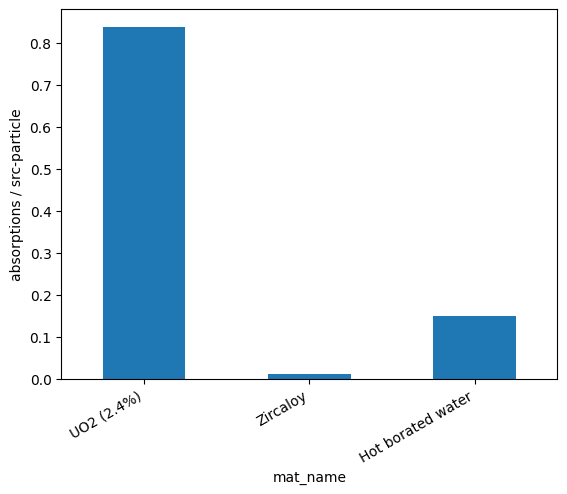

In [20]:
absorption_df = df[df['score'] == 'absorption']
absorption_df.plot('mat_name', 'mean', ylabel='absorptions / src-particle', kind='bar', legend=False)
plt.xticks(rotation=30, ha='right')
plt.show()